In [1]:
import pandas as pd
import numpy as np
import librosa
import cv2
import os
import glob
import seaborn as sns
from tqdm import tqdm
import IPython.display
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.io as pio
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"
import warnings
warnings.simplefilter("ignore")

import cosine_similarity as cs
import freq_dataset as fd
cos = cs.CosineSimilarity()
freq = fd.MakeFreqDataset()

s_path = "../../sounds/"

In [2]:
# 한글 폰트 설정
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

# 한글 사용시 마이너스 폰트가 깨지는 문제가 발생할 수 있으므로 설정 변경
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~')

In [52]:
o_path = list(set(glob.glob(f'{s_path}*/*/*')))
path_ls = [file[3:] for file in o_path if file.endswith(".mp3") or file.endswith(".wav")]
name_ls = [name.split('/')[-1][:-4] for name in path_ls]
label_ls = [name.split('/')[-3] for name in path_ls]
info_df = pd.DataFrame()
info_df['path'] = path_ls
info_df['label'] = label_ls
info_df['name'] = name_ls
info_df

,path,label,name
0,../sounds/human_voice/original_clean/c_058.mp3,human_voice,c_058
1,../sounds/animal/cats_dog_add_noise/cat_85_2.wav,animal,cat_85_2
2,../sounds/human_voice/read_women/3_2332.wav,human_voice,3_2332
3,../sounds/animal/염소 소리/GOAT (2).wav,animal,GOAT (2)
4,../sounds/animal/개 소리/1-59513-A-0.wav,animal,1-59513-A-0
...,...,...,...
22482,../sounds/human_voice/read_women/4_0881.wav,human_voice,4_0881
22483,../sounds/animal/고양이 소리/cat_77.wav,animal,cat_77
22484,../sounds/human_voice/read_women/2_0258.wav,human_voice,2_0258
22485,../sounds/human_voice/read_women/3_2124.wav,human_voice,3_2124


In [53]:
o_df = pd.read_csv("../files/freq_dataset_1113.csv", encoding='utf-8-sig')
o_df.drop(["Unnamed: 0", "label"], axis=1, inplace=True)
o_df['cate1'] = [p.split('/')[-3] for p in o_df['path']]
o_df['cate2'] = [p.split('/')[-1][:3] if p.split('/')[-2] == 'cats_dogs' else p.split('/')[-2] for p in o_df['path']]
o_df.drop(o_df[o_df['cate2']=='cats_dog_add_noise'].index, axis=0, inplace=True)
o_df['cate2'] = [c.replace("cat", "고양이") for c in o_df['cate2']]
o_df['cate2'] = [c.replace("dog", "개") for c in o_df['cate2']]
o_df['cate2'] = [c.replace(" ", "") for c in o_df['cate2']]
o_df['cate2'] = [c.replace("소리", "") for c in o_df['cate2']]
o_df = o_df[o_df['cate1'] == 'animal'].copy()
o_df

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
1,dr0shorse,../../sounds/animal/말 소리/dr0shorse.wav,1.353651,0.374280,0.095735,0.181595,0.006819,1492.603731,8.567513e+04,955.614463,...,12.378535,56.651711,-10.243791,28.035650,-3.035161,78.115898,1.781476,150.969696,animal,말
8,5-197446-A-7,../../sounds/animal/벌 소리/5-197446-A-7.wav,5.000000,0.459533,0.076533,0.055097,0.002021,2269.844202,1.710596e+05,2555.378258,...,-7.631099,15.183190,-3.202921,17.505238,-8.461825,13.419047,-3.178414,17.566444,animal,벌
38,dog_barking_108,../../sounds/animal/개 소리/dog_barking_108.wav,10.396689,0.659107,0.044288,0.041320,0.001408,3438.614128,9.251955e+05,2171.148015,...,11.429811,33.483120,-13.745112,28.966200,6.268610,26.215820,-7.755744,17.861032,animal,개
39,dog_barking_75,../../sounds/animal/cats_dogs/dog_barking_75.wav,2.593197,0.214954,0.096244,0.114834,0.006668,1103.800057,4.565354e+04,933.097892,...,-9.614342,409.729980,-9.015744,183.782593,0.607754,107.774826,1.981836,255.811737,animal,개
61,bird018,../../sounds/animal/새 소리/bird018.wav,3.007302,0.571848,0.057562,0.010360,0.000108,2694.216571,2.308462e+05,2418.067058,...,-8.622164,23.268013,-0.992545,24.511826,-5.178211,30.655552,-1.723059,18.721495,animal,새
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22397,dog_barking_84,../../sounds/animal/cats_dogs/dog_barking_84.wav,2.332336,0.228779,0.104588,0.075584,0.004076,1115.638823,2.511080e+04,922.167618,...,-6.154753,359.127319,-3.362175,128.277130,-1.667079,201.910492,2.802570,284.567505,animal,개
22442,Haliaeetus_leucocephalus_V2134_12_short,../../sounds/animal/새 소리/Haliaeetus_leucocepha...,6.661224,0.457008,0.097233,0.028743,0.000523,3088.048622,1.189858e+06,2939.443878,...,0.185399,36.920399,0.961222,35.249889,-6.753345,58.879513,4.617588,88.005615,animal,새
22463,4-164064-B-1,../../sounds/animal/닭 소리/4-164064-B-1.wav,5.000000,0.271937,0.133009,0.043096,0.004502,995.322730,1.177301e+06,896.919297,...,1.023258,15.948661,2.904371,40.248821,-3.512716,52.817539,2.830628,44.999092,animal,닭
22466,dog_barking_91,../../sounds/animal/개 소리/dog_barking_91.wav,12.000000,0.378320,0.092914,0.057439,0.005793,1411.745911,1.771185e+05,1335.584895,...,-0.317317,63.718636,-1.498194,45.553402,-3.695013,40.773537,-5.202814,35.384460,animal,개


<BarContainer object of 20 artists>

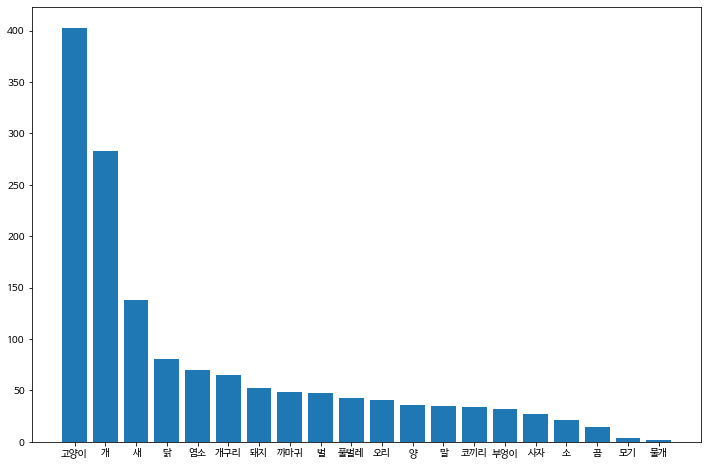

In [54]:
count_df = o_df.groupby('cate2').count().sort_values(by='name', ascending=False)
plt.figure(figsize=(12,8))
plt.bar(count_df.index, height=count_df['name'])

In [55]:
target_animals = ['고양이', '개', '새', '염소', '개구리', '돼지'] # count_df.index[:7].tolist()
print(target_animals)
result_df = pd.DataFrame()
for a in target_animals:
    temp = o_df[o_df['cate2']== a].copy()
    result_df = pd.concat([result_df, temp])
result_df.reset_index(inplace=True, drop=True)
result_df

['고양이', '개', '새', '염소', '개구리', '돼지']


,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
0,cat_35,../../sounds/animal/고양이 소리/cat_35.wav,11.000000,0.564131,0.067314,0.025919,0.001132,1429.288552,261200.244224,1612.312516,...,7.457832,35.269684,-2.501132,24.037781,1.829896,19.635115,1.710906,24.903175,animal,고양이
1,cat_141,../../sounds/animal/고양이 소리/cat_141.wav,0.941723,0.409352,0.080211,0.165388,0.006663,2596.732198,51354.257492,1524.065073,...,11.936614,40.342899,-8.426805,32.566399,6.773017,36.244740,-3.884769,35.042721,animal,고양이
2,1-47819-B-5,../../sounds/animal/고양이 소리/1-47819-B-5.wav,5.000000,0.438500,0.095735,0.005553,0.000041,2654.685243,175184.230280,2636.130122,...,-6.396316,33.586544,2.215581,33.081585,-8.530169,40.782906,-2.218924,86.056854,animal,고양이
3,cat_6,../../sounds/animal/cats_dogs/cat_6.wav,11.500000,0.675863,0.047439,0.028183,0.001136,1445.259695,518868.536251,1818.439417,...,0.885537,54.459682,8.594900,48.064693,6.021374,47.691811,2.553943,34.186470,animal,고양이
4,cat_110,../../sounds/animal/고양이 소리/cat_110.wav,1.272018,0.259342,0.095272,0.171115,0.010512,2171.597309,435236.553227,1793.060664,...,-13.009889,199.441040,-16.631609,92.513298,24.283859,269.449158,2.176965,76.417595,animal,고양이
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,5-117250-A-2,../../sounds/animal/돼지 소리/5-117250-A-2.wav,5.000000,0.065544,0.036910,0.055112,0.018143,267.630034,478867.809502,285.035466,...,-2.251482,36.933720,-0.861995,18.743097,0.220381,4.493680,0.575877,9.525250,animal,돼지
1007,3-253081-A-2,../../sounds/animal/돼지 소리/3-253081-A-2.wav,5.000000,0.552320,0.078417,0.100730,0.008411,2026.439319,487352.473765,2343.517116,...,-3.878862,38.829071,-1.641766,62.941196,-6.941632,35.460979,1.018114,21.876175,animal,돼지
1008,pig,../../sounds/animal/돼지 소리/pig.mp3,8.905624,0.573436,0.064510,0.045805,0.001301,1932.125612,600386.954829,2283.008340,...,-4.694106,38.609325,-6.377644,54.167938,-4.195568,35.042236,0.102446,21.183048,animal,돼지
1009,4-250869-C-2,../../sounds/animal/돼지 소리/4-250869-C-2.wav,5.000000,0.358594,0.091721,0.226199,0.017731,3274.341385,544450.018786,1909.878276,...,1.515077,84.095123,6.305935,63.521610,-2.965048,71.697731,4.351748,43.333389,animal,돼지


In [56]:
result_df['duration'].describe()

count    1011.000000
mean        6.928001
std         6.130195
min         0.221814
25%         2.909116
50%         5.000000
75%        10.896531
max        84.177007
Name: duration, dtype: float64

In [57]:
result_df[result_df['duration']<20].groupby('cate2').count().sort_values(by='name', ascending=False)

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1
cate2,,,,,,,,,,,,,,,,,,,,,
고양이,398,398,398,398,398,398,398,398,398,398,...,398,398,398,398,398,398,398,398,398,398
개,281,281,281,281,281,281,281,281,281,281,...,281,281,281,281,281,281,281,281,281,281
새,115,115,115,115,115,115,115,115,115,115,...,115,115,115,115,115,115,115,115,115,115
염소,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
개구리,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
돼지,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52


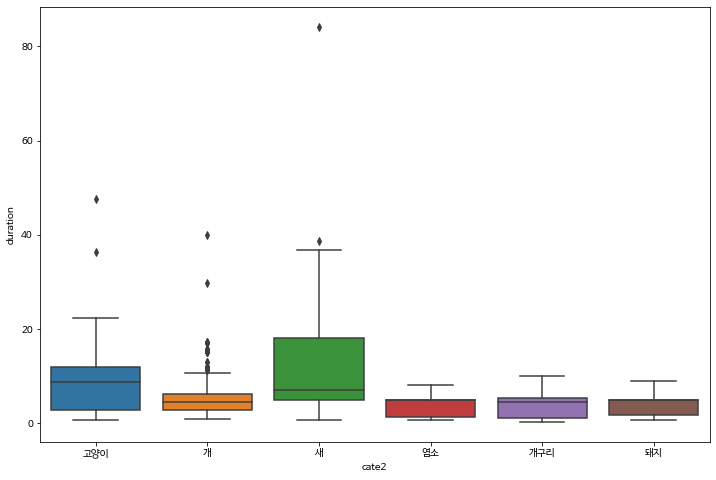

In [58]:
plt.figure(figsize=(12,8))
sns.boxplot(data=result_df, x='cate2', y='duration');

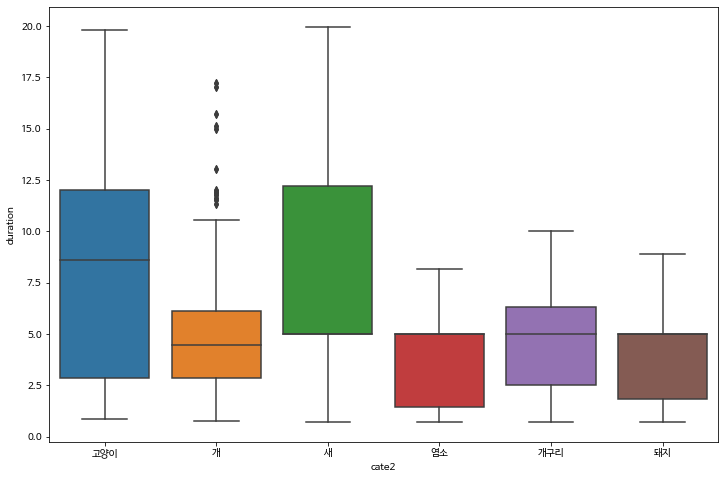

In [59]:
plt.figure(figsize=(12,8))
sns.boxplot(data=result_df[result_df['duration']<20][result_df['duration']>0.7], x='cate2', y='duration');

In [60]:
result_df.groupby('cate2').count()

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1
cate2,,,,,,,,,,,,,,,,,,,,,
개,283,283,283,283,283,283,283,283,283,283,...,283,283,283,283,283,283,283,283,283,283
개구리,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
고양이,403,403,403,403,403,403,403,403,403,403,...,403,403,403,403,403,403,403,403,403,403
돼지,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
새,138,138,138,138,138,138,138,138,138,138,...,138,138,138,138,138,138,138,138,138,138
염소,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70


In [61]:
long_out = result_df[result_df['duration']>20].index.tolist()
short_out = result_df[result_df['duration']<0.7].index.tolist()
print("너무 긴 outlier 제외: ", len(long_out))
print("너무 짧은 outlier 제외: ", len(short_out))

너무 긴 outlier 제외:  30
너무 짧은 outlier 제외:  19


In [62]:
final_df = result_df.drop(long_out+short_out, axis=0)
final_df

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
0,cat_35,../../sounds/animal/고양이 소리/cat_35.wav,11.000000,0.564131,0.067314,0.025919,0.001132,1429.288552,261200.244224,1612.312516,...,7.457832,35.269684,-2.501132,24.037781,1.829896,19.635115,1.710906,24.903175,animal,고양이
1,cat_141,../../sounds/animal/고양이 소리/cat_141.wav,0.941723,0.409352,0.080211,0.165388,0.006663,2596.732198,51354.257492,1524.065073,...,11.936614,40.342899,-8.426805,32.566399,6.773017,36.244740,-3.884769,35.042721,animal,고양이
2,1-47819-B-5,../../sounds/animal/고양이 소리/1-47819-B-5.wav,5.000000,0.438500,0.095735,0.005553,0.000041,2654.685243,175184.230280,2636.130122,...,-6.396316,33.586544,2.215581,33.081585,-8.530169,40.782906,-2.218924,86.056854,animal,고양이
3,cat_6,../../sounds/animal/cats_dogs/cat_6.wav,11.500000,0.675863,0.047439,0.028183,0.001136,1445.259695,518868.536251,1818.439417,...,0.885537,54.459682,8.594900,48.064693,6.021374,47.691811,2.553943,34.186470,animal,고양이
4,cat_110,../../sounds/animal/고양이 소리/cat_110.wav,1.272018,0.259342,0.095272,0.171115,0.010512,2171.597309,435236.553227,1793.060664,...,-13.009889,199.441040,-16.631609,92.513298,24.283859,269.449158,2.176965,76.417595,animal,고양이
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,5-117250-A-2,../../sounds/animal/돼지 소리/5-117250-A-2.wav,5.000000,0.065544,0.036910,0.055112,0.018143,267.630034,478867.809502,285.035466,...,-2.251482,36.933720,-0.861995,18.743097,0.220381,4.493680,0.575877,9.525250,animal,돼지
1007,3-253081-A-2,../../sounds/animal/돼지 소리/3-253081-A-2.wav,5.000000,0.552320,0.078417,0.100730,0.008411,2026.439319,487352.473765,2343.517116,...,-3.878862,38.829071,-1.641766,62.941196,-6.941632,35.460979,1.018114,21.876175,animal,돼지
1008,pig,../../sounds/animal/돼지 소리/pig.mp3,8.905624,0.573436,0.064510,0.045805,0.001301,1932.125612,600386.954829,2283.008340,...,-4.694106,38.609325,-6.377644,54.167938,-4.195568,35.042236,0.102446,21.183048,animal,돼지
1009,4-250869-C-2,../../sounds/animal/돼지 소리/4-250869-C-2.wav,5.000000,0.358594,0.091721,0.226199,0.017731,3274.341385,544450.018786,1909.878276,...,1.515077,84.095123,6.305935,63.521610,-2.965048,71.697731,4.351748,43.333389,animal,돼지


count    962.000000
mean       6.393424
std        4.386578
min        0.708209
25%        2.976485
50%        5.000000
75%       10.335170
max       19.957551
Name: duration, dtype: float64


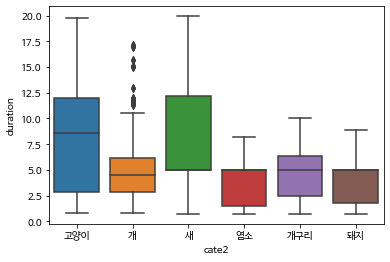

In [28]:
print(final_df['duration'].describe())
sns.boxplot(data=final_df, x='cate2', y='duration');

---
# 분류

In [29]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import pickle
import joblib
import seaborn as sns

In [30]:
def play_song(path):
    (file_dir, file_id) = os.path.split(path)
    print(file_id[:-4])
    print(IPython.display.display(IPython.display.Audio(path)))
def play_song_ls(cm_lr_df):
    for idx, path in enumerate(cm_lr_df['path']):
        print(cm_lr_df['pred'].iloc[idx])
        play_song(path)

In [31]:
def make_train_test(df):
    df = df.sample(frac=1)
    X = df.set_index('path').drop(['name','cate1','cate2','duration'], axis=1)
    y = df.set_index('path')[['cate2']].copy()
    print(f"X 개수:{len(X)}, y 개수:{len(y)}")
    print(df.groupby('cate2').count().sort_values('name')[['name']])
    return X, y

In [32]:
def model_fit_kfold(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cf = confusion_matrix(y_test, y_pred)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    print("accuracy:", round(accuracy_score(y_test, y_pred),6))
    print("recall:", round(recall_score(y_test, y_pred, labels=np.unique(y_test), average='macro'),6))
    print("f1 score:", round(f1_score(y_test, y_pred, labels=np.unique(y_test), average='macro'),6))
#     print("Cross Validation Score:", cross_val_score(model, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=kfold))
    ax = sns.heatmap(cf, annot=True, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), fmt="d", cmap="Blues")
    plt.title(str(model).split('(')[0])
    plt.show()
    return model, y_pred

In [33]:
def check_false_pred(y_pred):
    cm_lr_df = pd.DataFrame()
    cm_lr_df['answer'] = y_test['cate1'].tolist()
    cm_lr_df['pred'] = y_pred
    cm_lr_df['result'] = cm_lr_df['answer'] == cm_lr_df['pred']
    cm_lr_df['path'] = X_test.index
    cm_lr_df['cate2'] = [result_df[result_df['path']== p]['cate2'].iloc[0] for p in cm_lr_df['path']]
#     cm_lr_df['noise'] = [result_df[result_df['path']== p]['noise'].iloc[0] for p in cm_lr_df['path']]
#     cm_lr_df['name'] = [f"{p.split('/')[-2]}__{p.split('/')[-1][:-4]}" for p in cm_lr_df['path']]
#     [l.split('/')[-1]for l in cm_lr_df['path']]
    cm_lr_df = cm_lr_df[cm_lr_df['result']==False].sort_values(['answer', 'cate2'])
    return cm_lr_df

---
# Total songs

### Test dataset 만들기

In [63]:
count_df = final_df.groupby('cate2').count().sort_values(by='name', ascending=False)['name']
count_df

cate2
고양이    396
개      281
새      115
염소      68
개구리     51
돼지      51
Name: name, dtype: int64

<BarContainer object of 6 artists>

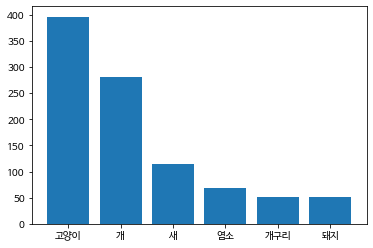

In [64]:
plt.bar(count_df.index, height=count_df)

In [65]:
### random samping으로 라벨별 test 데이터 뽑아두기
test_df = final_df.copy()
test_cat = test_df[test_df['cate2']=='고양이'].sample(n=100, random_state=1)
test_dog = test_df[test_df['cate2']=='개'].sample(n=100, random_state=13)
test_bird = test_df[test_df['cate2']=='새'].sample(n=30, random_state=13)
# test_chicken = test_df[test_df['cate2']=='닭'].sample(n=30, random_state=13)
test_goat = test_df[test_df['cate2']=='염소'].sample(n=20, random_state=13)
test_frog = test_df[test_df['cate2']=='개구리'].sample(n=15, random_state=13)
test_pig = test_df[test_df['cate2']=='돼지'].sample(n=15, random_state=13)
test_df = pd.concat([test_cat, test_dog, test_bird, test_goat, test_frog, test_pig])
test_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
개구리,15
돼지,15
염소,20
새,30
개,100
고양이,100


In [66]:
X_test, y_test = make_train_test(test_df)

X 개수:280, y 개수:280
       name
cate2      
개구리      15
돼지       15
염소       20
새        30
개       100
고양이     100


In [67]:
train_df = result_df.drop(test_df.index, axis=0)
train_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
돼지,37
개구리,50
염소,50
새,108
개,183
고양이,303


X 개수:731, y 개수:731
       name
cate2      
돼지       37
개구리      50
염소       50
새       108
개       183
고양이     303
---------DecisionTreeClassifier---------------
accuracy: 0.760714
recall: 0.580556
f1 score: 0.597427


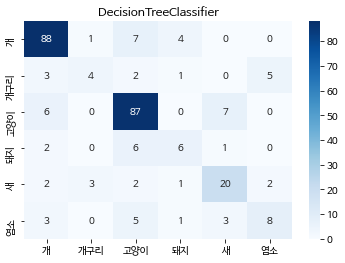

---------XGBClassifier---------------
accuracy: 0.864286
recall: 0.715556
f1 score: 0.748626


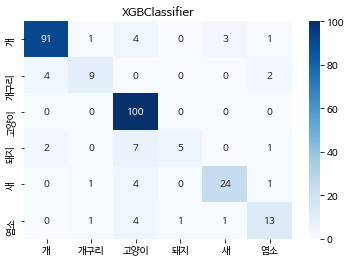

---------RandomForestClassifier---------------
accuracy: 0.807143
recall: 0.612222
f1 score: 0.650826


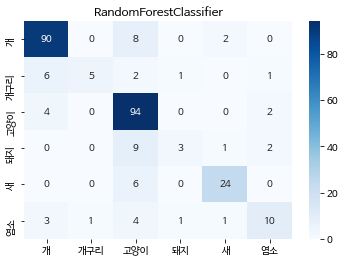

In [68]:
X_train, y_train = make_train_test(train_df)
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------XGBClassifier---------------
accuracy: 0.864286
recall: 0.715556
f1 score: 0.748626


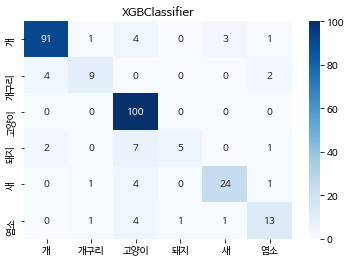

['models/XGB_animal6_oversampling_86.pkl']

In [69]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal6_82.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장
joblib.dump(xgb_model, 'models/XGB_animal6_86.pkl')

### 1. 5개의 라벨을 모두 같은 개수로 맞춰서 테스트
- groupby().sample
- RandomUnderSampler

In [149]:
# 방법1: pandas의 groupby().sample으로 라벨별 개수 맞추기
try1_df = train_df.groupby('cate2').sample(n=37, random_state=13)
X_train, y_train = make_train_test(try1_df)
print('------------------------')
X, y = make_train_test(pd.concat([test_df, try1_df]))

X 개수:222, y 개수:222
       name
cate2      
개        37
개구리      37
고양이      37
돼지       37
새        37
염소       37
------------------------
X 개수:502, y 개수:502
       name
cate2      
개구리      52
돼지       52
염소       57
새        67
개       137
고양이     137


---------DecisionTreeClassifier---------------
accuracy: 0.539286
recall: 0.53
f1 score: 0.470897


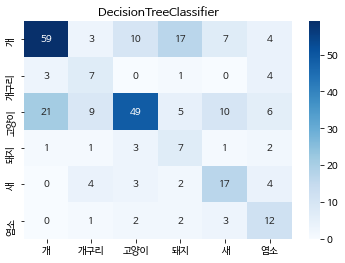

---------XGBClassifier---------------
accuracy: 0.685714
recall: 0.663889
f1 score: 0.612649


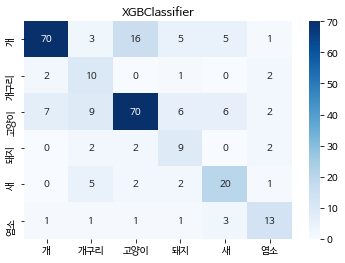

---------RandomForestClassifier---------------
accuracy: 0.603571
recall: 0.593889
f1 score: 0.54012


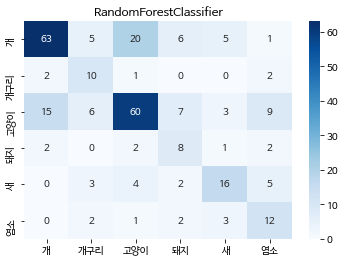

In [151]:
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

### 2. oversamping - imblearn.ADASYN
- SMOTE에 비해 ADASYN이 조금 더 사실적으로 데이터 간의 분산을 넣어 오버샘플링해준다 함

In [41]:
X_test, y_test = make_train_test(test_df)
train_df = result_df.drop(test_df.index, axis=0)
X_train, y_train = make_train_test(train_df)
X_train, y_train = ADASYN(random_state=1).fit_resample(X_train, y_train) # oversamping
y_train.reset_index().groupby('cate2').count()

X 개수:280, y 개수:280
       name
cate2      
개구리      15
돼지       15
염소       20
새        30
개       100
고양이     100
X 개수:731, y 개수:731
       name
cate2      
돼지       37
개구리      50
염소       50
새       108
개       183
고양이     303


,index
cate2,
개,312
개구리,295
고양이,303
돼지,305
새,334
염소,313


---------DecisionTreeClassifier---------------
accuracy: 0.732143
recall: 0.557778
f1 score: 0.553993


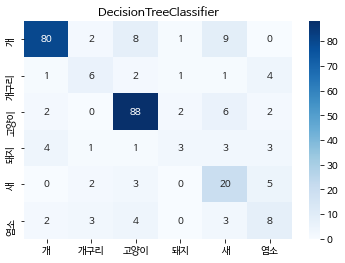

---------XGBClassifier---------------
accuracy: 0.828571
recall: 0.707778
f1 score: 0.702932


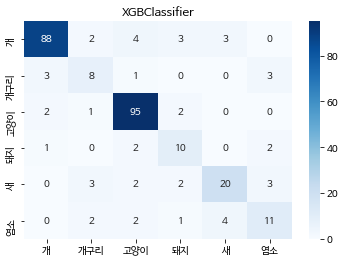

---------RandomForestClassifier---------------
accuracy: 0.835714
recall: 0.728333
f1 score: 0.726868


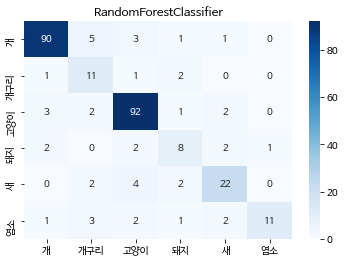

In [42]:
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------RandomForestClassifier---------------
accuracy: 0.835714
recall: 0.728333
f1 score: 0.726868


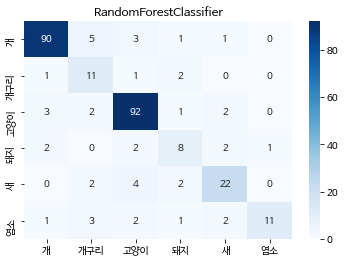

---------XGBClassifier---------------
accuracy: 0.828571
recall: 0.707778
f1 score: 0.702932


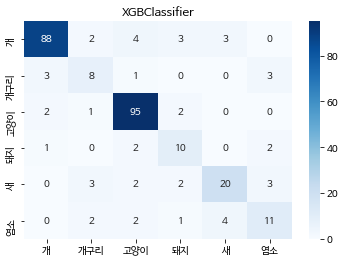

['models/XGB_animal6_oversampling_83.pkl']

In [44]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal6_oversampling_83.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장
joblib.dump(xgb_model, 'models/XGB_animal6_oversampling_83.pkl')

---
# short_df
- 노래 길이 백분위 50% 미만 데이터 기준

373
cate2
개      158
개구리     22
고양이    127
돼지      23
새       18
염소      25
Name: duration, dtype: int64
count    373.000000
mean       2.500763
std        1.205235
min        0.708209
25%        1.384535
50%        2.332336
75%        3.415601
max        4.996417
Name: duration, dtype: float64


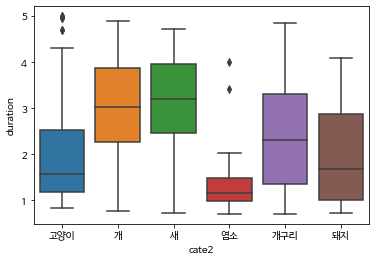

In [70]:
short_df = final_df[final_df['duration']<np.percentile(final_df['duration'], 50)]#[final_df['duration']>np.percentile(final_df['duration'], 25)]
print(len(short_df))
print(short_df.groupby('cate2')['duration'].count())
print(short_df['duration'].describe())
sns.boxplot(data=short_df, x='cate2', y='duration');

## Test dataset 만들기

In [81]:
### random samping으로 라벨별 test 데이터 뽑아두기
test_df = short_df.copy()
test_cat = test_df[test_df['cate2']=='고양이'].sample(n=50, random_state=1)
test_dog = test_df[test_df['cate2']=='개'].sample(n=50, random_state=13)
test_bird = test_df[test_df['cate2']=='새'].sample(n=7, random_state=13)
# test_chicken = test_df[test_df['cate2']=='닭'].sample(n=30, random_state=13)
test_goat = test_df[test_df['cate2']=='염소'].sample(n=7, random_state=13)
test_frog = test_df[test_df['cate2']=='개구리'].sample(n=10, random_state=13)
test_pig = test_df[test_df['cate2']=='돼지'].sample(n=7, random_state=13)
test_df = pd.concat([test_cat, test_dog, test_bird, test_goat, test_frog, test_pig])
test_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
돼지,7
새,7
염소,7
개구리,10
개,50
고양이,50


In [82]:
X_test, y_test = make_train_test(test_df)

X 개수:131, y 개수:131
       name
cate2      
돼지        7
새         7
염소        7
개구리      10
개        50
고양이      50


In [83]:
train_df = short_df.drop(test_df.index, axis=0)
train_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
새,11
개구리,12
돼지,16
염소,18
고양이,77
개,108


### 0. 그대로 테스트 

X 개수:242, y 개수:242
       name
cate2      
새        11
개구리      12
돼지       16
염소       18
고양이      77
개       108
---------DecisionTreeClassifier---------------
accuracy: 0.801527
recall: 0.628571
f1 score: 0.655466


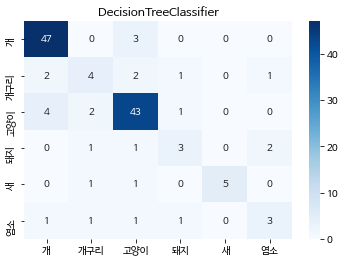

---------XGBClassifier---------------
accuracy: 0.870229
recall: 0.664762
f1 score: 0.677998


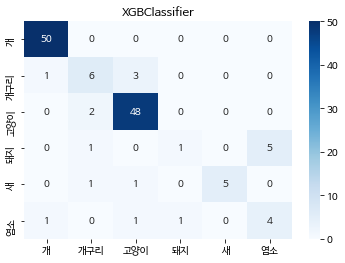

---------RandomForestClassifier---------------
accuracy: 0.847328
recall: 0.634286
f1 score: 0.636137


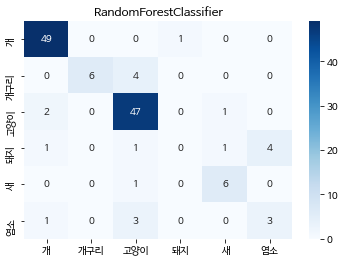

---------RandomForestClassifier---------------
accuracy: 0.847328
recall: 0.634286
f1 score: 0.636137


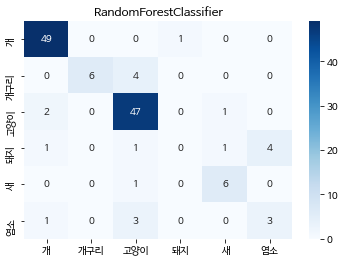

---------XGBClassifier---------------
accuracy: 0.870229
recall: 0.664762
f1 score: 0.677998


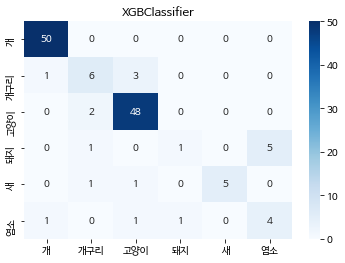

['models/XGB_animal6_under3s_87.pkl']

In [85]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal6_under3s_84.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장
joblib.dump(rf_model, 'models/XGB_animal6_under3s_87.pkl')

### 0. 그대로 테스트

In [ ]:
X_train, y_train = make_train_test(train_df)
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

### 1. 5개의 라벨을 모두 같은 개수로 맞춰서 테스트
- groupby().sample
- RandomUnderSampler

In [165]:
# 방법1: pandas의 groupby().sample으로 라벨별 개수 맞추기
try1_df = train_df.groupby('cate2').sample(n=10, random_state=13)
X_train, y_train = make_train_test(try1_df)
print('------------------------')
X, y = make_train_test(pd.concat([test_df, try1_df]))

X 개수:60, y 개수:60
       name
cate2      
개        10
개구리      10
고양이      10
돼지       10
새        10
염소       10
------------------------
X 개수:191, y 개수:191
       name
cate2      
돼지       17
새        17
염소       17
개구리      20
개        60
고양이      60


---------LogisticRegression---------------
accuracy: 0.137405
recall: 0.304762
f1 score: 0.214619


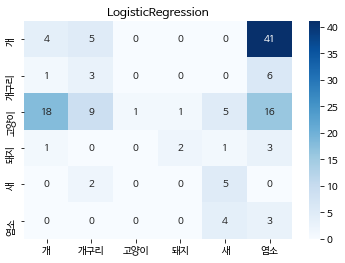

---------DecisionTreeClassifier---------------
accuracy: 0.412214
recall: 0.492381
f1 score: 0.418028


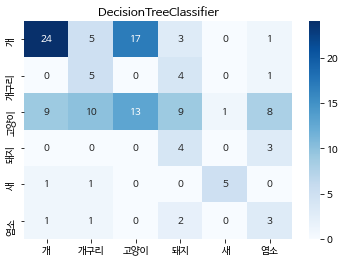

---------XGBClassifier---------------
accuracy: 0.625954
recall: 0.578571
f1 score: 0.515094


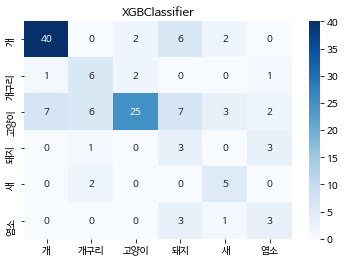

---------RandomForestClassifier---------------
accuracy: 0.694656
recall: 0.628095
f1 score: 0.560734


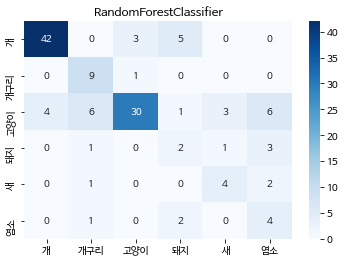

In [166]:
print("---------LogisticRegression---------------")
lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------RandomForestClassifier---------------
accuracy: 0.694656
recall: 0.628095
f1 score: 0.560734


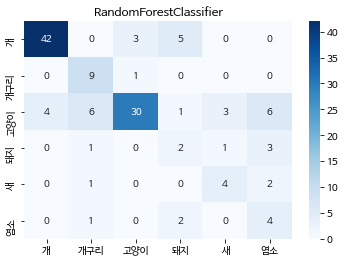

['models/RF_animal6_under3s_69.pkl']

In [167]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal6_under3s_69.pkl')

### 2. oversamping - imblearn.ADASYN
- SMOTE에 비해 ADASYN이 조금 더 사실적으로 데이터 간의 분산을 넣어 오버샘플링해준다 함

In [78]:
X_test, y_test = make_train_test(test_df)
train_df = short_df.drop(test_df.index, axis=0)
X_train, y_train = make_train_test(train_df)
X_train, y_train = ADASYN(random_state=1).fit_resample(X_train, y_train) # oversamping
y_train.reset_index().groupby('cate2').count()

X 개수:131, y 개수:131
       name
cate2      
돼지        7
새         7
염소        7
개구리      10
개        50
고양이      50
X 개수:242, y 개수:242
       name
cate2      
새        11
개구리      12
돼지       16
염소       18
고양이      77
개       108


,index
cate2,
개,108
개구리,106
고양이,102
돼지,108
새,113
염소,111


---------DecisionTreeClassifier---------------
accuracy: 0.801527
recall: 0.608095
f1 score: 0.624097


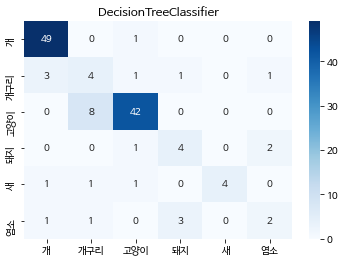

---------XGBClassifier---------------
accuracy: 0.900763
recall: 0.732381
f1 score: 0.746749


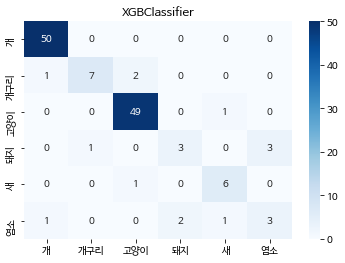

---------RandomForestClassifier---------------
accuracy: 0.862595
recall: 0.749524
f1 score: 0.750144


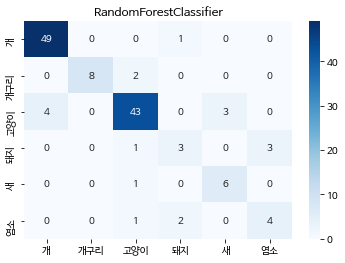

In [79]:
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------XGBClassifier---------------
accuracy: 0.900763
recall: 0.732381
f1 score: 0.746749


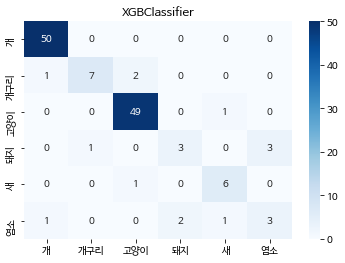

['models/XGB_animal6_under3s_oversampling_90.pkl']

In [80]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal6_under3s_oversampling_83.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장
joblib.dump(rf_model, 'models/XGB_animal6_under3s_oversampling_90.pkl')

---
# long_df
- 노래 길이 백분위 50% 이상 데이터 기준

589
cate1
animal    589
Name: duration, dtype: int64
count    589.000000
mean       8.858556
std        3.850962
min        5.000000
25%        5.000000
50%        8.202449
75%       12.000000
max       19.957551
Name: duration, dtype: float64


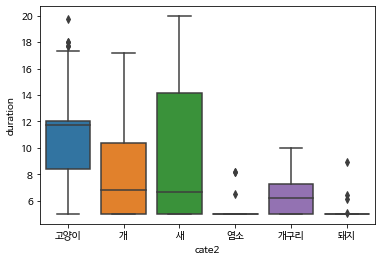

In [98]:
long_df = final_df[final_df['duration']>=np.percentile(final_df['duration'], 50)]#[final_df['duration']<=np.percentile(final_df['duration'], 75)]
print(len(long_df))
print(long_df.groupby('cate1')['duration'].count())
print(long_df['duration'].describe())
sns.boxplot(data=long_df, x='cate2', y='duration');

In [99]:
X, y = make_train_test(long_df)

X 개수:589, y 개수:589
       name
cate2      
돼지       28
개구리      29
염소       43
새        97
개       123
고양이     269


## Test dataset 만들기

In [100]:
### random samping으로 라벨별 test 데이터 뽑아두기
test_df = long_df.copy()
test_cat = test_df[test_df['cate2']=='고양이'].sample(n=50, random_state=1)
test_dog = test_df[test_df['cate2']=='개'].sample(n=50, random_state=13)
test_bird = test_df[test_df['cate2']=='새'].sample(n=40, random_state=13)
# test_chicken = test_df[test_df['cate2']=='닭'].sample(n=30, random_state=13)
test_goat = test_df[test_df['cate2']=='염소'].sample(n=15, random_state=13)
test_frog = test_df[test_df['cate2']=='개구리'].sample(n=9, random_state=13)
test_pig = test_df[test_df['cate2']=='돼지'].sample(n=8, random_state=13)
test_df = pd.concat([test_cat, test_dog, test_bird, test_goat, test_frog, test_pig])
test_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
돼지,8
개구리,9
염소,15
새,40
개,50
고양이,50


In [101]:
X_test, y_test = make_train_test(test_df)

X 개수:172, y 개수:172
       name
cate2      
돼지        8
개구리       9
염소       15
새        40
개        50
고양이      50


In [102]:
train_df = long_df.drop(test_df.index, axis=0)
train_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
개구리,20
돼지,20
염소,28
새,57
개,73
고양이,219


### 0. 그대로 테스트

X 개수:417, y 개수:417
       name
cate2      
개구리      20
돼지       20
염소       28
새        57
개        73
고양이     219
---------DecisionTreeClassifier---------------
accuracy: 0.703488
recall: 0.54037
f1 score: 0.547837


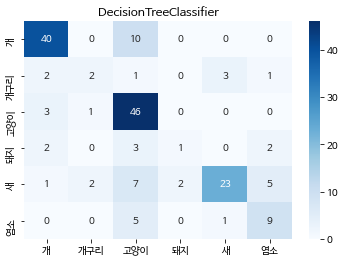

---------XGBClassifier---------------
accuracy: 0.755814
recall: 0.586574
f1 score: 0.605036


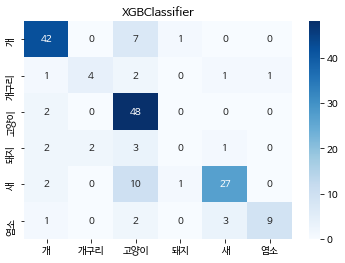

---------RandomForestClassifier---------------
accuracy: 0.674419
recall: 0.474259
f1 score: 0.4909


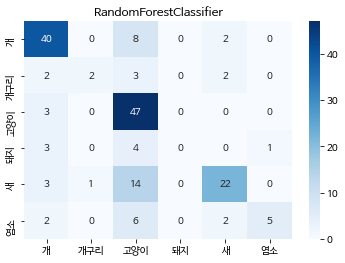

In [103]:
X_train, y_train = make_train_test(train_df)
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

### 1. 5개의 라벨을 모두 같은 개수로 맞춰서 테스트
- groupby().sample
- RandomUnderSampler

In [182]:
# 방법1: pandas의 groupby().sample으로 라벨별 개수 맞추기
try1_df = train_df.groupby('cate2').sample(n=20, random_state=13)
X_train, y_train = make_train_test(try1_df)
print('------------------------')
X, y = make_train_test(pd.concat([test_df, try1_df]))

X 개수:120, y 개수:120
       name
cate2      
개        20
개구리      20
고양이      20
돼지       20
새        20
염소       20
------------------------
X 개수:292, y 개수:292
       name
cate2      
돼지       28
개구리      29
염소       35
새        60
개        70
고양이      70


---------DecisionTreeClassifier---------------
accuracy: 0.447674
recall: 0.43963
f1 score: 0.396545


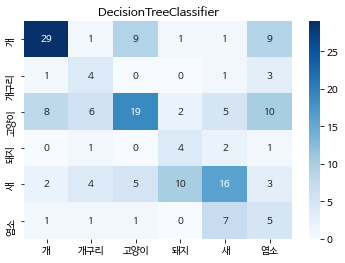

---------XGBClassifier---------------
accuracy: 0.639535
recall: 0.5875
f1 score: 0.552843


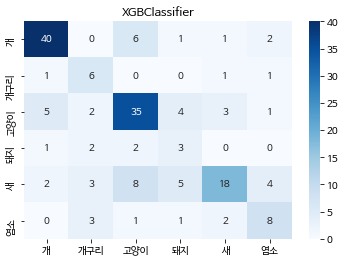

---------RandomForestClassifier---------------
accuracy: 0.598837
recall: 0.513611
f1 score: 0.48732


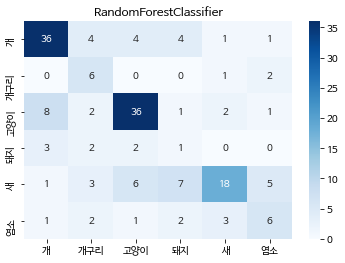

In [183]:
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------RandomForestClassifier---------------
accuracy: 0.64
recall: 0.64
f1 score: 0.658059


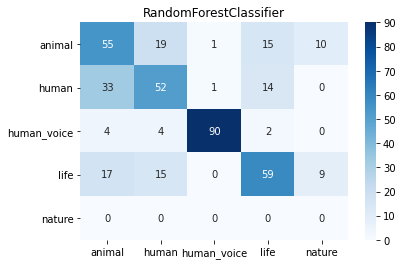

['models/RF_over3s_64.pkl']

In [42]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장: 정확도 64
joblib.dump(rf_model, 'models/RF_over3s_64.pkl')

### 2. oversamping - imblearn.ADASYN
- SMOTE에 비해 ADASYN이 조금 더 사실적으로 데이터 간의 분산을 넣어 오버샘플링해준다 함

In [104]:
X_test, y_test = make_train_test(test_df)
train_df = long_df.drop(test_df.index, axis=0)
X_train, y_train = make_train_test(train_df)
X_train, y_train = ADASYN(random_state=13).fit_resample(X_train, y_train) # oversamping
y_train.reset_index().groupby('cate2').count()

X 개수:172, y 개수:172
       name
cate2      
돼지        8
개구리       9
염소       15
새        40
개        50
고양이      50
X 개수:417, y 개수:417
       name
cate2      
개구리      20
돼지       20
염소       28
새        57
개        73
고양이     219


,index
cate2,
개,208
개구리,219
고양이,219
돼지,221
새,209
염소,220


---------DecisionTreeClassifier---------------
accuracy: 0.645349
recall: 0.526296
f1 score: 0.530667


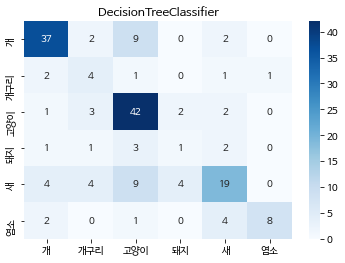

---------XGBClassifier---------------
accuracy: 0.790698
recall: 0.676759
f1 score: 0.689561


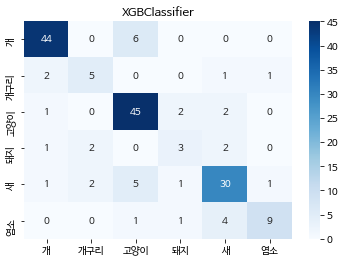

---------RandomForestClassifier---------------
accuracy: 0.72093
recall: 0.582407
f1 score: 0.588322


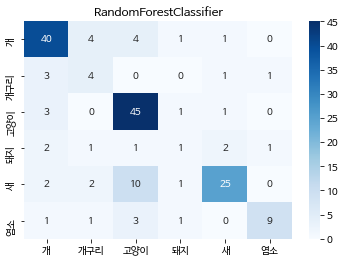

In [106]:
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------XGBClassifier---------------
accuracy: 0.790698
recall: 0.676759
f1 score: 0.689561


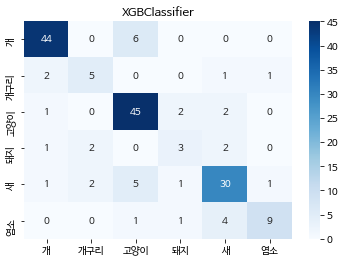

['models/XGB_animal6_over3s_oversampling_79.pkl']

In [108]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장: 정확도 75
joblib.dump(rf_model, 'models/RF_animal6_over3s_oversampling_75.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장: 정확도 75
joblib.dump(rf_model, 'models/XGB_animal6_over3s_oversampling_79.pkl')

---
## 모델 저장하기
- short song
- long song

In [188]:
list(set(glob.glob(f'models/RF_animal6*')))

['models/RF_animal6_under3s_oversampling_83.pkl',
 'models/RF_animal6_over3s_oversampling_75.pkl',
 'models/RF_animal6_80.pkl',
 'models/RF_animal6_under3s_69.pkl']